In [286]:
import pandas as pd
import EDA
import preprocessing
import classification

column_credit = ['CustomerID', 'CheckingAccountBalance', 'DebtsPaid', 'SavingsAccountBalance',
                 'CurrentOpenLoanApplications']
df_credit = pd.read_csv('ds-credit.tsv', sep='\s+', header=-1, names=column_credit)

column_app = ['CustomerID', 'LoanPayoffPeriodInMonths', 'LoanReason', 'RequestedAmount', 'InterestRate',
              'Co-Applicant']
df_app = pd.read_csv('ds-app.tsv', sep='\s+', header=-1, names=column_app)

column_borrower = ['CustomerID', 'YearsAtCurrentEmployer', 'YearsInCurrentResidence', 'Age', 'RentOrOwnHome',
                   'TypeOfCurrentEmployment', 'NumberOfDependantsIncludingSelf']
df_borrower = pd.read_csv('ds-borrower.csv', sep='\s+', index_col=False, names=column_borrower, header=0)

column_result = ['CustomerID', 'WasTheLoanApproved']
df_result = pd.read_csv('ds-result.tsv', sep='\s+', header=-1, names=column_result)
df_result = df_result.drop_duplicates()  # Drop the duplicated results

In [641]:
na = preprocessing.NA(df_borrower)
na.to_num('CustomerID')
df_borrower = na.drop('CustomerID')

na = preprocessing.NA(df_result)
na.to_num('CustomerID')
df_result = na.drop('CustomerID')

mg = preprocessing.Merge([df_credit, df_app, df_borrower, df_result])
df_all = mg.transform('CustomerID')
df = df_all.loc[(df_all.WasTheLoanApproved == 'Y') | (df_all.WasTheLoanApproved == 'N')].dropna()
df['Age'] = pd.to_numeric(df.Age)
df['LoanPayoffPeriodInMonths'] = pd.to_numeric(df.LoanPayoffPeriodInMonths)

In [642]:
import numpy as np

In [643]:
df['Amount'] = df.apply(lambda x: np.log(x.RequestedAmount) / x.NumberOfDependantsIncludingSelf, 1)

In [644]:
df['Home']=df.apply(lambda row: str(row.NumberOfDependantsIncludingSelf) + str(row.RentOrOwnHome), 1)

In [645]:
df['JobSaving']=df.apply(lambda row: str(row.TypeOfCurrentEmployment) +'_job_' + str(row.SavingsAccountBalance) + '_saving_', 1)

In [646]:
df=df.drop('NumberOfDependantsIncludingSelf', 1)

In [647]:
df=df.drop('RentOrOwnHome', 1)

In [648]:
df=df.drop('TypeOfCurrentEmployment', 1)

In [649]:
df = df.drop('CustomerID',1)
df1 = df.drop(['RequestedAmount','Age','WasTheLoanApproved'],1)
en = preprocessing.Encode()
en.one_hot(df1)
df2 = en.encoder.transform(df1)
df = preprocessing.Encode().ordinal(df)

x = pd.concat([df.RequestedAmount.reset_index(drop=True), df.Age.reset_index(drop=True), pd.DataFrame(df2.toarray())],1) 
y = df.WasTheLoanApproved.values.reshape(-1,1)

In [650]:
from sklearn.ensemble import RandomForestClassifier

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


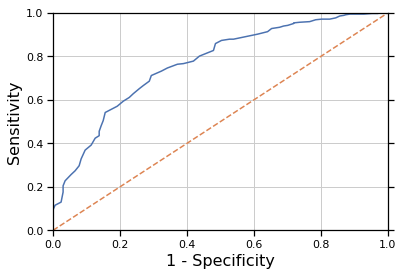

0.7670365321230738


In [676]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
classification.Roc(rf, 'predict_proba').plot(x, y)

In [652]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

In [671]:

ys = cross_val_predict(rf, x[:300], y[:300], cv=5, method='predict_proba')[:,1]
roc_auc_score(y[:300], ys)

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7943776520509195